# Generating Digits using an AutoEncoder

## Creating A Variational AutoEncoder

In [1]:
import tensorflow as tf
from functools import partial
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
tf.logging.set_verbosity(tf.logging.ERROR)

indims = 28 * 28
n_hidden_1 = 500
n_hidden_2 = 500
n_hidden_3 = 20
n_hidden_4 = n_hidden_2
n_hidden_5 = n_hidden_1
outdims = indims

learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
fully_connected_layer = partial(
    tf.layers.dense, 
    activation = tf.nn.elu, 
    kernel_initializer = initializer
)

X = tf.placeholder(tf.float32, [None, indims])

hidden_1 = fully_connected_layer(X, n_hidden_1)
hidden_2 = fully_connected_layer(hidden_1, n_hidden_2)

mean  = fully_connected_layer(hidden_2, n_hidden_3, activation = None)
gamma = fully_connected_layer(hidden_2, n_hidden_3, activation = None)
noise = tf.random_normal(tf.shape(gamma), dtype = tf.float32)
hidden_3 = mean + tf.exp(0.5 * gamma) * noise

hidden_4 = fully_connected_layer(hidden_3, n_hidden_4)
hidden_5 = fully_connected_layer(hidden_4, n_hidden_5)
logits   = fully_connected_layer(hidden_5, outdims, activation = None)
outputs  = tf.sigmoid(logits)

cross_entropy       = tf.nn.sigmoid_cross_entropy_with_logits(labels = X, logits = logits)
reconstruction_loss = tf.reduce_sum(cross_entropy)
latent_loss         = 0.5 * tf.reduce_sum(tf.exp(gamma) + tf.square(mean) - 1 - gamma)
loss                = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation  = optimizer.minimize(loss)

init = tf.global_variables_initializer()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Training

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

mnist = input_data.read_data_sets("/tmp/data/")

digits = 60
epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    
    for epoch in range(epochs):
        num_batches = mnist.train.num_examples // batch_size
        for iteration in range(num_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            loss_val   = loss.eval(feed_dict = {X:X_batch}) 
            sess.run(training_operation, feed_dict = {X: X_batch})
            
    codings_rnd = np.random.normal(size = [digits, n_hidden_3])
    outputs_val = outputs.eval(feed_dict = {hidden_3: codings_rnd})

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Results

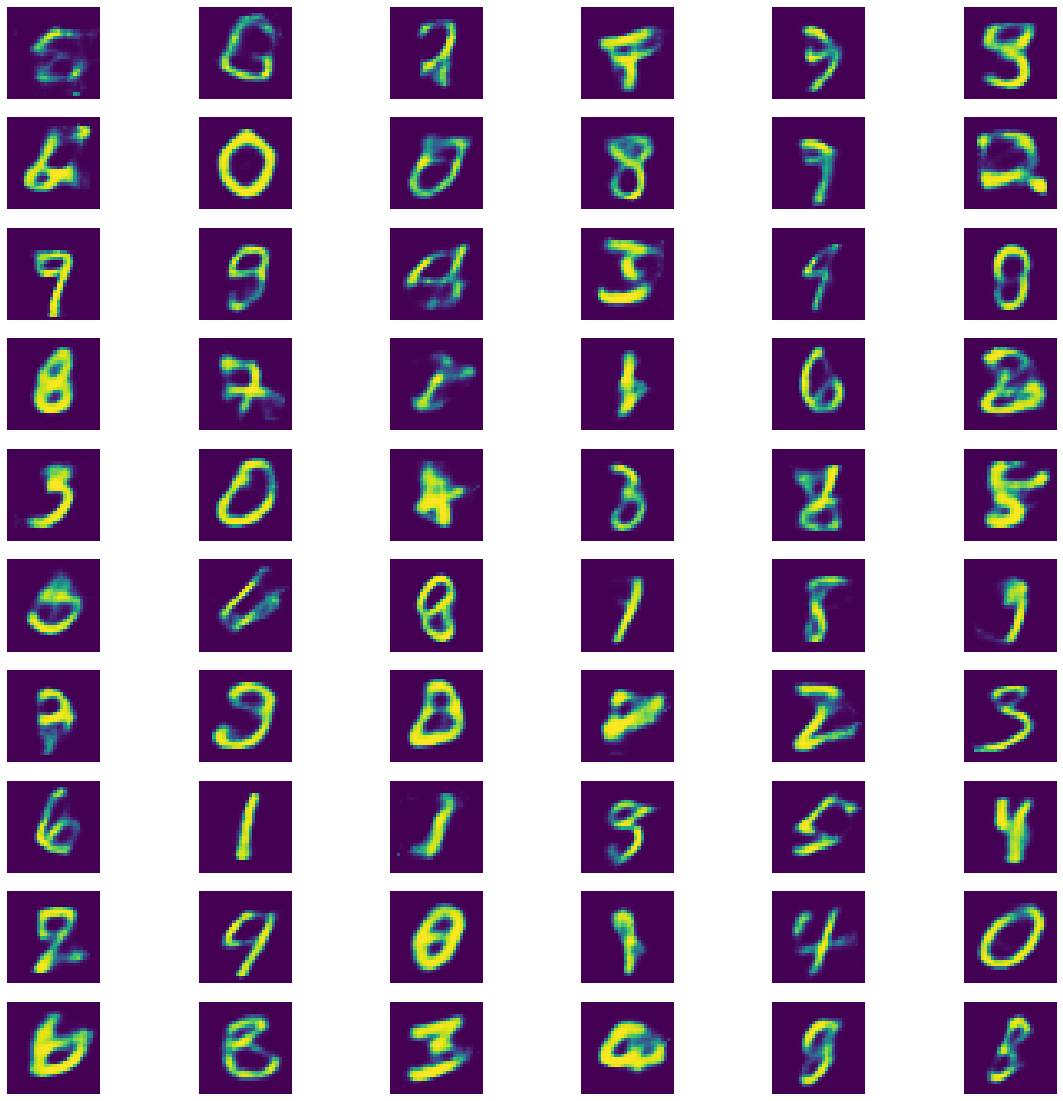

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 6, figsize = (20, 20))
i = 0
for row in range(0, 10):
    for col in range(0, 6):
        current_image = np.array(outputs_val[i]).reshape(28, 28)
        axes[row, col].axis('off')
        axes[row, col].imshow(current_image)
        i += 1